In [4]:
import numpy as np
import healpy as hp
import pandas as pd
import seaborn as sns

import astropy.table
import astropy.coordinates as ac
from astropy import units as u

import matplotlib.gridspec as gridspec

import completeness_utils

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# For esthetics, this is optional
sns.set_context("talk")

Empirical completeness maps for RR Lyrae surveys (updates for Gaia DR3)
==========

The following notebook shows how to reproduce the results presented in Mateu (2024, RNAAS): 2D and 3D completeness maps for Gaia DR3 SOS and combined GaiaDR3SOS+PS1+ASAS-SN-II catalogues. The maps were produced following the methodology presented in [Mateu et al. 2020](https://ui.adsabs.harvard.edu/link_gateway/2020MNRAS.496.3291M/doi:10.1093/mnras/staa1676).

Load catalogue data
=========

In [6]:
print("Reading Gaia...")
gaia = pd.read_csv("../data/DR3_SOS.full.csv.gz")

print("Reading ASAS+PS1...") #see map_computing_examples for the procedure to produce this catalogue (see documentation in Mateu et al. 2020)
asasps1 = pd.read_csv("../data/asas_snii_j19_ps1_bonafide_s17.csv.gz")

Reading Gaia...
Reading ASAS+PS1...


Keep columns for useful quality filters

In [7]:
sc_asasps1  =  ac.SkyCoord(ra=np.array(asasps1["ra"])*u.deg, 
                           dec=np.array(asasps1["dec"])*u.deg,  
                           distance=np.array(asasps1["distance"])*u.kpc, 
                           frame='icrs', obstime="J2013.0", equinox="J2000")
sc_gaia =  ac.SkyCoord(ra=np.array(gaia["ra"])*u.deg,      
                       dec=np.array(gaia["dec"])*u.deg, 
                       distance=np.array(gaia["Dist_M18_sfdAG"])*u.kpc, 
                       frame='icrs', obstime="J2016.5")

sc_asasps1.RRType = asasps1["RRType"]
sc_gaia.RRType = gaia["Type"]

sc_asasps1.G = asasps1["Gmag"]
sc_gaia.G = gaia["phot_g_mean_mag"]

sc_gaia.ruwe = gaia["ruwe"]
sc_gaia.bep = gaia["phot_bp_rp_excess_factor_norm"]


Compute Map vs Distance along a line of sight
--------

Below is an example computation of the complentess of the Gaia catalogue along a selected line of sight,
for RR Lyrae of a given type. Results for subsets produced with commonly used quality filters for Gaia DR3  are compared to those for the full catalogue. 

All
ruwe<1.4
BEP<3


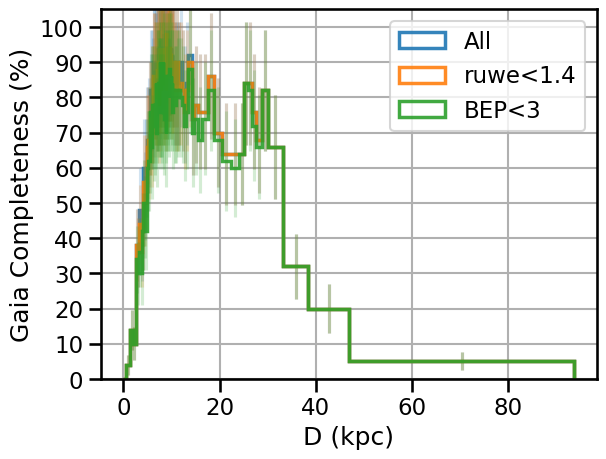

In [8]:
los_coo = ac.SkyCoord(10.*u.deg, 0*u.deg, frame='galactic')
#Select RR Lyrae type
rrt="RRab"
#rrt="RRc"  #uncommment this line for RR Lyrae of type c

#Maps are computed for some of the most used quality filters (as well as no filter)
m_no_filter = sc_gaia.G<21.
m_ruwe = sc_gaia.ruwe<1.4
m_bep = sc_gaia.bep<3
m_all = [m_no_filter, m_ruwe, m_bep, m_ruwe & m_bep]
m_lab = ["All","ruwe<1.4", "BEP<3", "ruwe<1.4 & BEP<3"]

#This is a quick test along a l.o.s.
for ii in range(len(m_all))[:3]:
    print(m_lab[ii])
    rs, C, eC, Ntot_r, Ncommon_r, Cmean = completeness_utils.completeness_los(los_coo, sc_asasps1[sc_asasps1.RRType==rrt], 
                                                           sc_gaia[ (sc_gaia.RRType==rrt) & m_all[ii]], 
                                                           los_size=20*u.deg, sky_tol=3*u.arcsec,
                                                           Nmin=50, verbose=False)
    
    #----Plot---------------------------------------------
    ro = (rs[:-1] + rs[1:])/2.   
    ax=plt.subplot(111)
    ax.hist(ro,weights=C*100,bins=rs,histtype='step',lw=2.5,color=f'C{ii}',alpha=0.9,label=m_lab[ii])
    ax.errorbar(ro,C*100,yerr=eC*100,marker=None,alpha=0.2,color=f'C{ii}',ls='none')

ax.legend()
ax.set_ylim(0,105)
ax.yaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlabel("D (kpc)")
ax.set_ylabel("Gaia Completeness (%)")
ax.grid()

Compute Gaia DR3 SOS's 3D maps for RRab and RRc
================

Following the previus example, the full 3D completeness map for Gaia dR3 SOS is produced by iterating along the different lines of sight in a healpix map of a given level.

In [9]:
#--------------Gaia's 3D selection function (from x-match against ASAS+PS1)-------------------
nside=2**2
npix = hp.nside2npix(nside)
hpi = np.arange(npix,dtype=int) #healpix indices for current map 
nest=False
los, bos = hp.pix2ang(nside, hpi, lonlat=True, nest=nest)

m_no_filter = sc_gaia.G<21.
m_full = (sc_gaia.G<24) 
m_ruwe = sc_gaia.ruwe<1.4
m_bep = sc_gaia.bep<3

m_all = [m_no_filter, m_ruwe, m_bep, m_ruwe & m_bep]
m_lab = ["all","ruwe_lt_1.4", "BEP_lt3", "ruwe_lt_1.4_BEP_lt_3"]


#All surveys
rrt = 'RRab'
#rrt = 'RRc'  #uncommment this line for RR Lyrae of type c
for ii in range(len(m_all)):

    print(f"--- Computing maps with {m_lab[ii]} mask ----")
    mm = m_all[ii]
    
    cat1_coo = sc_asasps1[sc_asasps1.RRType==rrt] #Cat1 is the reference catalogue
    cat2_coo = sc_gaia[(sc_gaia.RRType==rrt) & mm] #Cat2 is the problem catalogue
    outlabel = dict(gaia = "gaiadr3.sos", ps1="ps1_wgdr3ref", asas="asas_wgdr3ref")
    skytols  = dict(gaia = 1.*u.arcsec, ps1=1.*u.arcsec, asas=5.*u.arcsec)
    fill     = dict(gaia=True, ps1=False, asas=False)
        
    survey = 'gaia'
    
    print(f"Computing completeness for {rrt} in {survey} ...")  

    hpis, ls, bs, ris, rfs = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
    Cs, eCs = np.array([]), np.array([])
    j=0

    for lo, bo in zip(los,bos) :

        #Completeness vs r for lo,bo
        if j % 20 == 0 :   print(f" Computing C(r) for lo={lo:6.2f}, bo={bo:+5.2f} ({j}/{los.size})")      
        los_coo = ac.SkyCoord(lo*u.deg, bo*u.deg, frame='galactic')
        ro, C, eC, Ntot_r, Ncommon_r, Cmean = completeness_utils.completeness_los(los_coo, cat1_coo, cat2_coo, fill_with_ecliptic_opposite=fill[survey],
                                                           los_size=(8.2*2)*u.deg, sky_tol=skytols[survey],
                                                           Nmin=50, verbose=False)

        hpis= np.append(hpis, hpi[j]*np.ones_like(C))
        ls = np.append(ls, lo*np.ones_like(C))
        bs = np.append(bs, bo*np.ones_like(C))
        ris= np.append(ris, ro[:-1])
        rfs= np.append(rfs, ro[1:])
        Cs = np.append(Cs, C)
        eCs= np.append(eCs, eC)
        j+=1
    
    
        #Store in DataFrame     
        printout = pd.DataFrame(data=dict(hpix=hpis,l=ls,b=bs,D_o=ris,D_f=rfs,C=Cs,eC=eCs))
        #Print tex table for paper
        outname=f"{outlabel[survey]}.filt_{m_lab[ii]}.{rrt.lower()}"
    #     astropy.io.ascii.write(astropy.table.Table.from_pandas(printout), 
    #                             output=f"maps/completeness3d.{outname}.tex", overwrite=True,
    #                             Writer=astropy.io.ascii.Latex,
    #                             formats={'hpix':'%4d','l':'%6.2f','b':'%+5.2f',"D_o":"%5.1f","D_f":"%5.1f","C":"%4.2f","eC":"%4.2f"})
    
        # printout_t = astropy.table.Table.from_pandas(printout)
        # astropy.io.ascii.write(printout_t,output=f"RRL_SF_data/completeness3d.{outname}.dat", 
        #                  overwrite=True,format='fixed_width', delimiter=' ',
        #                  formats={'hpix':'%4d','l':'%6.2f','b':'%+5.2f',"D_o":"%5.1f","D_f":"%5.1f","C":"%4.2f","eC":"%4.2f"})

    #Print csv table for convenience
    #printout.to_csv(f"../maps/completeness3d.{outname}.csv",index=False,)

print("Done")

--- Computing maps with all mask ----
Computing completeness for RRc in gaia ...
 Computing C(r) for lo= 45.00, bo=+78.28 (0/192)
 Computing C(r) for lo=255.00, bo=+54.34 (20/192)
 Computing C(r) for lo=  0.00, bo=+30.00 (40/192)
 Computing C(r) for lo=101.25, bo=+19.47 (60/192)
 Computing C(r) for lo=180.00, bo=+9.59 (80/192)
 Computing C(r) for lo=281.25, bo=+0.00 (100/192)
 Computing C(r) for lo= 11.25, bo=-19.47 (120/192)
 Computing C(r) for lo= 90.00, bo=-30.00 (140/192)
 Computing C(r) for lo=191.25, bo=-41.81 (160/192)
 Computing C(r) for lo= 22.50, bo=-66.44 (180/192)
--- Computing maps with ruwe_lt_1.4 mask ----
Computing completeness for RRc in gaia ...
 Computing C(r) for lo= 45.00, bo=+78.28 (0/192)
 Computing C(r) for lo=255.00, bo=+54.34 (20/192)
 Computing C(r) for lo=  0.00, bo=+30.00 (40/192)
 Computing C(r) for lo=101.25, bo=+19.47 (60/192)
 Computing C(r) for lo=180.00, bo=+9.59 (80/192)
 Computing C(r) for lo=281.25, bo=+0.00 (100/192)
 Computing C(r) for lo= 11.25,

Summary plots for Completeness vs Distance at: fixed l varying b and fixed b, varying l
-------------
Here we show how to reproduce Fig. 10 of (Mateu et al. 2020)[https://ui.adsabs.harvard.edu/link_gateway/2020MNRAS.496.3291M/doi:10.1093/mnras/staa1676] comparing completeness along 5 lines of sight for RR Lyrae of type ab and c.

In [1]:
gaia3Dab = pd.read_csv("../maps/completeness3d.gaiadr3.sos.filt_All.rrab.csv",dtype=dict(hpix=int))
gaia3Dc  = pd.read_csv("../maps/completeness3d.gaiadr3.sos.filt_All.rrc.csv",dtype=dict(hpix=int))

NameError: name 'pd' is not defined

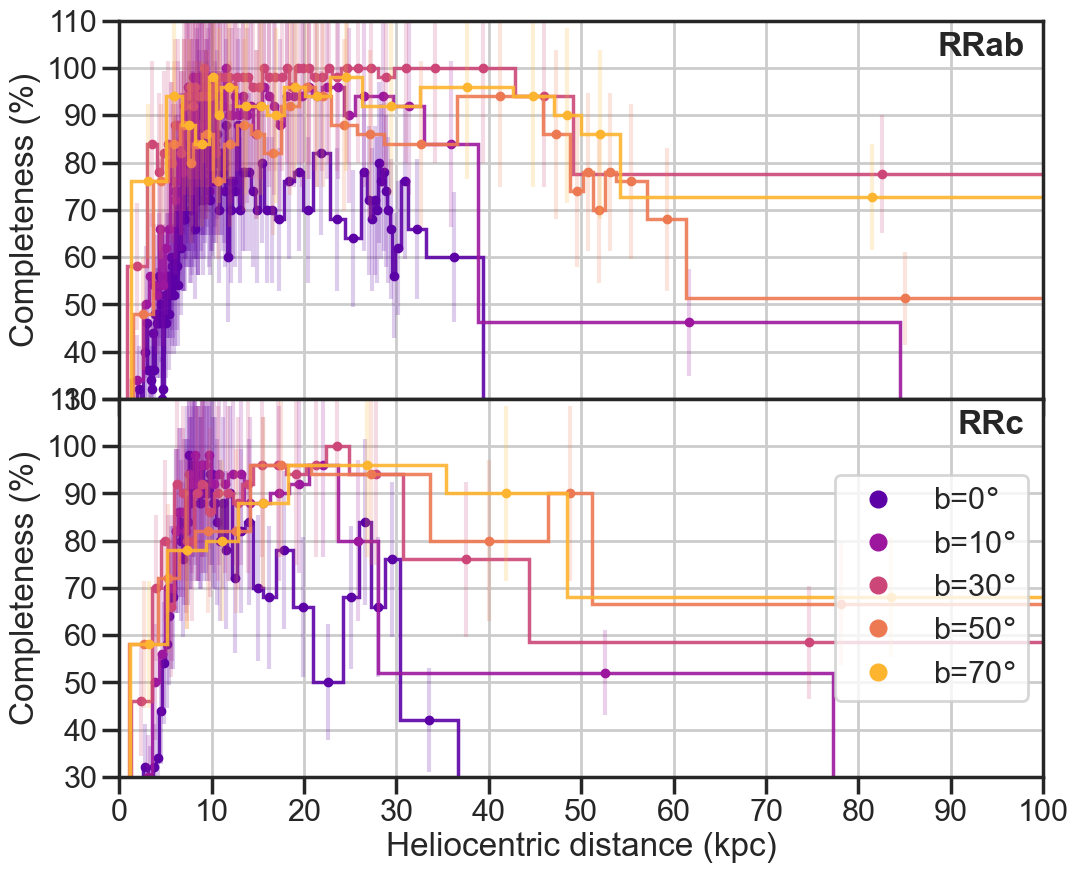

In [106]:
sns.set_style('ticks')
sns.set_context('poster')


fig=plt.figure(1,figsize=(11,9), )
fig.subplots_adjust(left=0.12,right=0.96,top=0.98,bottom=0.14,hspace=0.)
ax=fig.add_subplot(211,)   
ax1=fig.add_subplot(212)   

ls=[5,45,90,145,180]
bs=[0,10,30,50,70]
cols=sns.color_palette("plasma", len(ls))

completeness_map = gaia3Dab

for jj in range(len(ls)) : #np.arange(0,360.,90.):
 
 bo=5.
 lo=ls[jj]
 label = f"l={lo}$\degree$" 
    
 lo=20.
 bo=bs[jj]
 label=f"b={bo}$\degree$"   

 #RRAB    
 coo = ac.SkyCoord(l = lo*u.deg, b = bo*u.deg, frame = 'galactic')
 losC = completeness_utils.query_3d_map(gaia3Dab ,coo)   
    
 rmid = (losC.D_f+losC.D_o)/2.
 rs = np.append(np.min(losC["D_o"]),losC["D_f"])

 ax.plot(rmid,losC.C*100,'.',color=cols[jj],label=f"l={lo}$\degree$")
 #The histogram plot gives a better representation of the data. Completeness was estimated in (non-uniform) distance bins to ensure a given Poisson noise.
 ax.hist(rmid,weights=losC.C*100,bins=rs,histtype='step',lw=2.5,color=cols[jj],alpha=0.9)
 ax.errorbar(rmid,losC.C*100,yerr=losC.eC*100,marker=None,alpha=0.2,color=cols[jj],ls='none')
 
 #RRC   
 losC = completeness_utils.query_3d_map(gaia3Dc ,coo)   
    
 rmid = (losC.D_f+losC.D_o)/2.
 rs = np.append(np.min(losC["D_o"]),losC["D_f"])

 ax1.plot(rmid,losC.C*100,'.',color=cols[jj],label=label)
 #The histogram plot gives a better representation of the data. Completeness was estimated in (non-uniform) distance bins to ensure a given Poisson noise.
 ax1.hist(rmid,weights=losC.C*100,bins=rs,histtype='step',lw=2.5,color=cols[jj],alpha=0.9)
 ax1.errorbar(rmid,losC.C*100,yerr=losC.eC*100,marker=None,alpha=0.2,color=cols[jj],ls='none')

    
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax1.xaxis.set_major_locator(plt.MultipleLocator(10))

ax.yaxis.set_major_locator(plt.MultipleLocator(10))
ax1.yaxis.set_major_locator(plt.MultipleLocator(10))

ax.grid(which='major')
ax1.grid(which='major')

#ax.legend(markerscale=2, ncol=2, loc='lower left')

ax.set_xlim(0,100)
ax1.set_xlim(0,100)
ax.xaxis.set_ticklabels([])
ax1.set_xlabel('Heliocentric distance (kpc)')

ax.set_ylabel('Completeness (%)')
ax1.set_ylabel('Completeness (%)')

ax.text(0.98,0.97,'RRab',fontweight='bold',ha='right',va='top', transform=ax.transAxes)
ax1.text(0.98,0.97,'RRc',fontweight='bold',ha='right',va='top', transform=ax1.transAxes)


ax.set_ylim(30,110)
ax1.set_ylim(30,110)

#ax1.legend()
ax1.legend(markerscale=2, loc='center right')#, loc='lower left')

Compute 2D and plot completeness maps (G magnitude ranges)
============================
The following example shows how to produce 2D completeness maps (sky plots) for Gaia DR3 SOS RR Lyrae in three different magnitude ranges

/Users/cmateu/miniconda3/envs/mine/lib/python3.11/site-packages/rrl_completeness-1.0.0-py3.11.egg/completeness_utils/__init__.py:209: RuntimeWarning: invalid value encountered in divide
/Users/cmateu/miniconda3/envs/mine/lib/python3.11/site-packages/rrl_completeness-1.0.0-py3.11.egg/completeness_utils/__init__.py:210: RuntimeWarning: invalid value encountered in divide
/Users/cmateu/miniconda3/envs/mine/lib/python3.11/site-packages/healpy-1.16.6-py3.11-macosx-10.9-x86_64.egg/healpy/visufunc.py:1503: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  ax.graticule(dpar=dpar, dmer=dmer, coord=coord, local=local, **kwds)


100.0 66.66666666666667 65.30322226327982
100.0 53.333333333333336 52.183975798429714
85.0 92.40506329113924 87.3644206607246
15 18 filling
66.66666666666667 84.61538461538461 75.8492243666262
15 18 filling
48.226950354609926 84.61538461538461 78.73757380507881
18 21 filling
20.0 66.66666666666667 58.797575548588206
18 21 filling


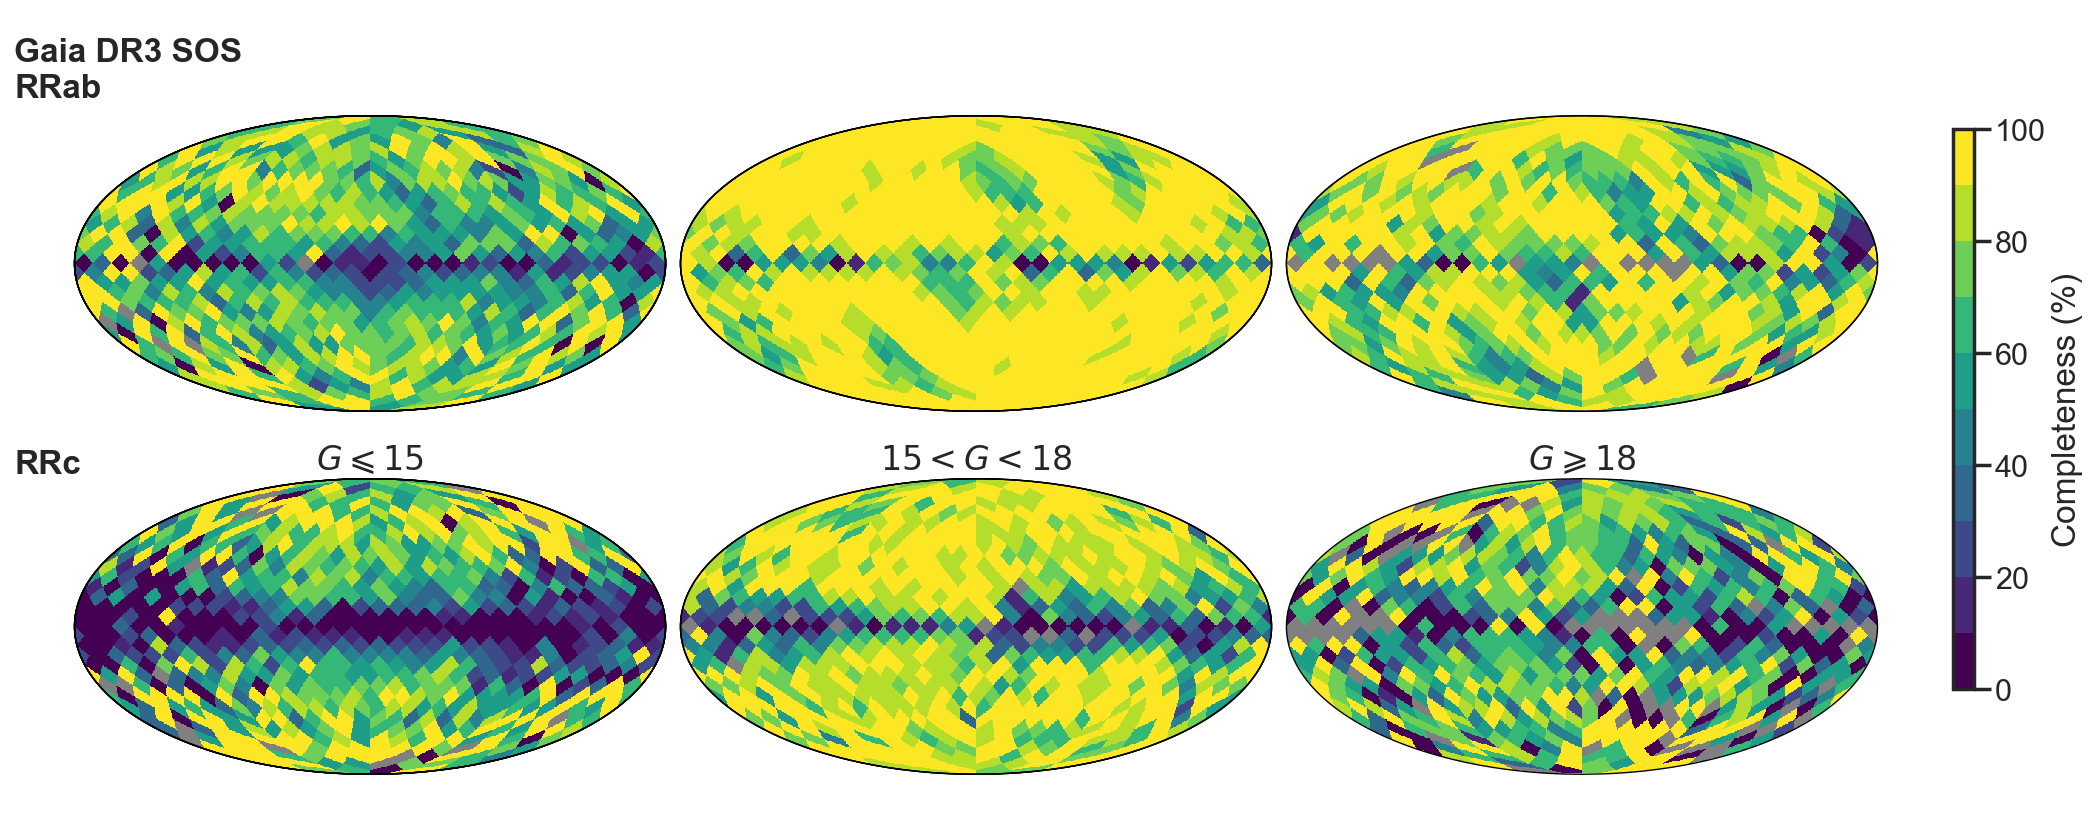

In [107]:
ccmap=plt.get_cmap("viridis",10)
ccmap.set_bad('gray')
ccmap.set_under('w')

rrtypes=["RRab","RRc"]


fig=plt.figure(1,figsize=(21,8))
fig.subplots_adjust(wspace=0.03,hspace=0.02,left=0.03,right=0.89,bottom=0.01,top=0.9)
gs=gridspec.GridSpec(nrows=2,ncols=3,hspace=0.04,wspace=0.02)

gth_o=[10.,15,18]
gth_f=[15,18,21]
#glabel=["$13\leqslant G\leqslant 15$","$15<G<18$","$G\geqslant 18$"]
glabel=[f"$G \leqslant {gth_f[0]}$",
        f"${gth_o[1]}<G<{gth_f[1]}$",
        f"$G\geqslant {gth_o[2]}$"]

for jj in range(3):
    
 for ii in  range(2):
       
    nside=2**3 

    rrt = rrtypes[ii]    

    m_ruwe = sc_gaia.ruwe<1.4
    m_bep = sc_gaia.bep<3

    pmasks = (sc_asasps1.G > gth_o[jj]) & (sc_asasps1.G <= gth_f[jj])
    gmasks = (sc_gaia.G > gth_o[jj]) & (sc_gaia.G <= gth_f[jj]) & m_ruwe
     
    cat1_coo = sc_asasps1[(sc_asasps1.RRType==rrt) & pmasks] #Cat1 is the reference catalogue
    cat2_coo = sc_gaia[(sc_gaia.RRType==rrt) & gmasks] #Cat2 is the problem catalogue

    #Compute Gaia's completeness maps (valid within each survey's magnitude range) 
    Cap, CG = completeness_utils.compute_completeness_map(cat1_coo, cat2_coo, nside=nside, 
                                                         tol=3.*u.arcsec, verbose=False)
    print(np.nanmedian(Cap),np.nanmedian(CG),np.nanmean(CG),)

    if gth_f[jj]<17: CG_filled = CG.copy()
    else:    
        print(gth_o[jj],gth_f[jj],'filling')
        CG_filled = completeness_utils.fill_with_ecliptic_opposite(np.array(CG))
     
    axt=plt.subplot(gs[ii,jj])

    #Gaia Completeness: CG = NGP/P
    if ii==1: title=glabel[jj] #'%.1f<G<%.1f' % (gth_o[jj],gth_f[jj])
    else: title=""  
    hp.mollview(CG_filled, cbar=False, title=title, 
                unit = 'Completeness ',min=0, max=100., hold=True, cmap=ccmap);
    hp.graticule(color='w',alpha=0.,verbose=False,dmer=90.); 
    #if jj==0 and ii==0: 
    #  hp.projtext(179.999,50.,"RRab ",lonlat=True,ha="right")
 
   # if jj==0 and ii==0: 
   #   print 'aqui',jj,ii  
   #   hp.projtext(179.999,50.,"RRc ",lonlat=True,ha="right")

fig = plt.gcf()
axt = plt.gca()
#axt = plt.subplot(gs[0,0])
image = axt.get_images()[0]
#cbax=plt.axes((0.96,0.15,0.015,0.4))

cbax=plt.axes((0.925,0.15,0.01,0.7))
cbar = fig.colorbar(image,cax=cbax,orientation="vertical")#,vmin=0,vmax=100.)
cbar.set_label("Completeness (%)")
# cbar.set_ticks(plt.MultipleLocator(10))
# cbax.tick_params(pad=0.13)    

tax=plt.axes((0.,0.,0.1,1.),frameon=False,)
tax.text(0.02,0.89,"Gaia DR3 SOS \nRRab",transform=tax.transAxes,fontweight='bold')
tax.text(0.02,0.42,"RRc",transform=tax.transAxes,fontweight='bold')
tax.axis('off')
    
#plt.savefig("VCSOS_PS1_RRL_completeness_G_maps.png")
plt.savefig("/Users/cmateu/trabajo/research/rrl_distances/extendedGDR2_RRL/paper_rnaas_dr3_completeness/fig_dr3_maps.png")

Compute and plot 2D maps in DISTANCE ranges 
======================
The following example shows how to produce 2D completeness maps (sky plots) for Gaia DR3 SOS RR Lyrae in three different *distance* ranges

(0.0, 1.0, 0.0, 1.0)

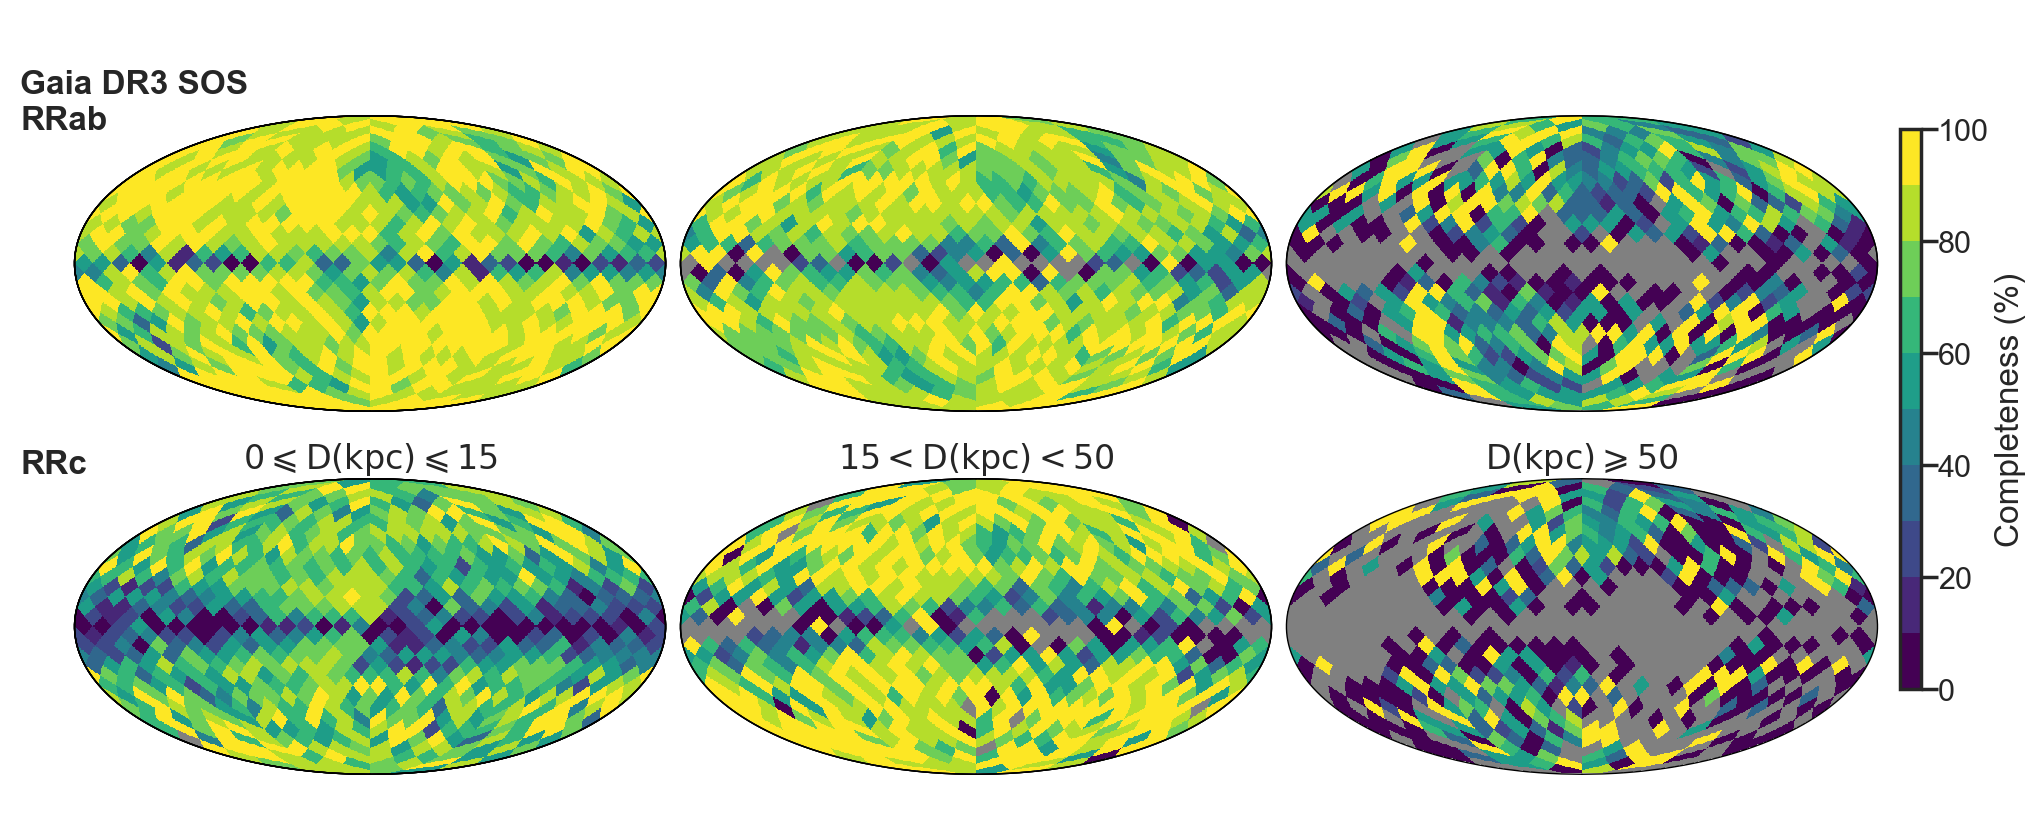

In [132]:
cmap = "viridis"
ccmap=plt.get_cmap(cmap,10)
ccmap.set_bad('gray')
ccmap.set_under('w')

rrtypes=["RRab","RRc"]

fig=plt.figure(1,figsize=(21,8))
fig.subplots_adjust(wspace=0.03,hspace=0.02,left=0.03,right=0.89,bottom=0.01,top=0.9)
gs=gridspec.GridSpec(nrows=2,ncols=3,hspace=0.04,wspace=0.02)

gth_o=[0,15,50]
gth_f=[15,50,100]
dd = "\mathrm{D(kpc)}"
glabel=[f"${gth_o[0]} \leqslant {dd} \leqslant {gth_f[0]}$",
        f"${gth_o[1]}< {dd} <{gth_f[1]}$",
        f"$ {dd} \geqslant {gth_o[2]}$"]

for jj in range(3):
    
 for ii in  range(2):
       
    if jj<=1: nside=2**3 
    if jj==2 and ii==1: nside=2**3    

    rrt = rrtypes[ii]    

    pmasks = (sc_asasps1.distance.kpc > gth_o[jj]) & (sc_asasps1.distance.kpc <= gth_f[jj])
    gmasks = (sc_gaia.distance.kpc > gth_o[jj]) & (sc_gaia.distance.kpc <= gth_f[jj])
     
    cat1_coo = sc_asasps1[(sc_asasps1.RRType==rrt) & pmasks] #Cat1 is the reference catalogue
    cat2_coo = sc_gaia[(sc_gaia.RRType==rrt) & gmasks] #Cat2 is the problem catalogue

    #Compute Gaia's completeness maps (valid within each survey's magnitude range) 
    Cap, CG = completeness_utils.compute_completeness_map(cat1_coo, cat2_coo, nside=nside, 
                                                         tol=1.*u.arcsec, verbose=False)

    # if jj==0: CG_filled = CG
    # else:    
    #     print(gth_o[jj],gth_f[jj],'filling')
    CG_filled = completeness_utils.fill_with_ecliptic_opposite(np.array(CG))
        
     
    axt=plt.subplot(gs[ii,jj])

    #Gaia Completeness: CG = NGP/P
    if ii==1: title=glabel[jj] #'%.1f<G<%.1f' % (gth_o[jj],gth_f[jj])
    else: title=""  
    hp.mollview(CG_filled, cbar=False, title=title, 
                unit = 'Completeness ',min=0, max=100., hold=True, cmap=ccmap);
    hp.graticule(color='w',alpha=0.,verbose=False,dmer=90.); 
    #if jj==0 and ii==0: 
    #  hp.projtext(179.999,50.,"RRab ",lonlat=True,ha="right")
 
   # if jj==0 and ii==0: 
   #   print 'aqui',jj,ii  
   #   hp.projtext(179.999,50.,"RRc ",lonlat=True,ha="right")

fig = plt.gcf()
axt = plt.gca()
#axt = plt.subplot(gs[0,0])
image = axt.get_images()[0]
#cbax=plt.axes((0.96,0.15,0.015,0.4))

cbax=plt.axes((0.9,0.15,0.01,0.7))
cbar = fig.colorbar(image,cax=cbax,orientation="vertical")#,vmin=0,vmax=100.)
cbar.set_label("Completeness (%)")
# cbar.set_ticks(plt.MultipleLocator(10))
cbax.tick_params(pad=0.13)    

tax=plt.axes((0.,0.,0.1,1.),frameon=False,)
tax.text(0.05,0.85,"Gaia DR3 SOS \nRRab",transform=tax.transAxes,fontweight='bold')
tax.text(0.05,0.42,"RRc",transform=tax.transAxes,fontweight='bold')
tax.axis('off')



Single Plot RRab+c in given distance range
=============================

Gaia N RRab 17216
Gaia N RRc 12787


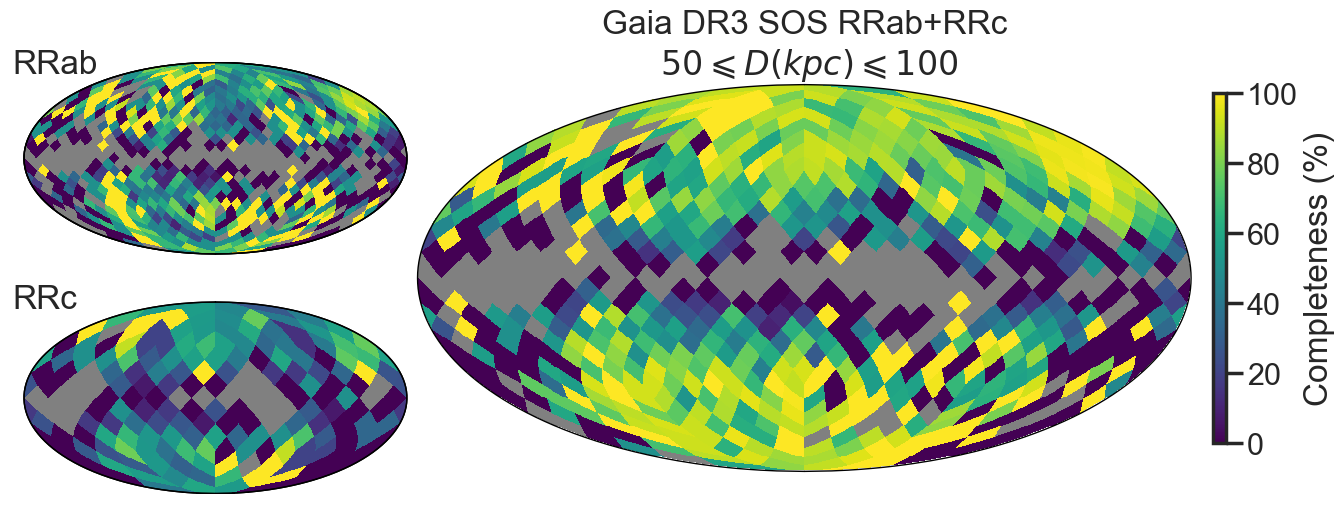

In [145]:
cmap = "viridis"
ccmap=plt.get_cmap(cmap,10)
ccmap.set_bad('gray')
ccmap.set_under('w')

fig=plt.figure(1,figsize=(13,5))
fig.subplots_adjust(wspace=0.02,hspace=0.02,left=0.01,right=0.91,bottom=0.01,top=0.95)
gs=gridspec.GridSpec(nrows=2,ncols=3,hspace=0.04,wspace=0.02)

gth_o=[50.,1.,2.]
gth_f=[100.,2.,2.]
glabel=[f"${gth_o[0]} \leqslant D\leqslant {gth_f[0]}$","x","x"]
rrtypes=["RRab","RRc"]
    
for ii in  range(2):
       
    if ii==0: nside=2**3 
    else: nside=2**2 
        
    jj=0
    rrt = rrtypes[ii]    

    pmasks = (sc_asasps1.distance.kpc > gth_o[jj]) & (sc_asasps1.distance.kpc <= gth_f[jj])
    gmasks = (sc_gaia.distance.kpc > gth_o[jj]) & (sc_gaia.distance.kpc <= gth_f[jj])

    print('Gaia N',rrt,((sc_gaia.RRType==rrt) & gmasks).sum()) 
    
    cat1_coo = sc_asasps1[(sc_asasps1.RRType==rrt) & pmasks] #Cat1 is the reference catalogue
    cat2_coo = sc_gaia[(sc_gaia.RRType==rrt) & gmasks] #Cat2 is the problem catalogue

    #Compute Gaia's completeness maps (valid within each survey's magnitude range) 
    Cap, CG = completeness_utils.compute_completeness_map(cat1_coo, cat2_coo, nside=nside, 
                                                         tol=1.*u.arcsec, verbose=False)

    CG_filled = completeness_utils.fill_with_ecliptic_opposite(np.array(CG))      
     
    axt=plt.subplot(gs[ii,jj])

    #Gaia Completeness: CG = NGP/P
    if ii==1: title=glabel[jj] #'%.1f<G<%.1f' % (gth_o[jj],gth_f[jj])
    else: title=""  
    hp.mollview(CG_filled, cbar=False, title='', 
                unit = 'Completeness ',min=0, max=100., hold=True, cmap=cmap);
    hp.graticule(color='w',alpha=0.,verbose=False,dmer=90.); 

fig = plt.gcf()
axt = plt.gca()
#axt = plt.subplot(gs[0,0])
image = axt.get_images()[0]
#cbax=plt.axes((0.96,0.15,0.015,0.4))

cbax=plt.axes((0.925,0.15,0.01,0.7))
cbar = fig.colorbar(image,cax=cbax,orientation="vertical")#,vmin=0,vmax=100.)
cbar.set_label("Completeness (%)")
# cbar.set_ticks(plt.MultipleLocator(10))
# cbax.tick_params(pad=0.13)    

tax=plt.axes((0.,0.,0.1,1.),frameon=False,)
tax.text(0.02,0.89,"RRab",transform=tax.transAxes,fontweight='normal')
tax.text(0.02,0.42,"RRc",transform=tax.transAxes,fontweight='normal')
tax.axis('off')

#====================================================
#RRab+RRc map
nside =2**3

cat1_coo = sc_asasps1[pmasks] #Cat1 is the reference catalogue
cat2_coo = sc_gaia[gmasks] #Cat2 is the problem catalogue

#Compute Gaia's completeness maps (valid within each survey's magnitude range) 
Cap, CG = completeness_utils.compute_completeness_map(cat1_coo, cat2_coo, nside=nside, 
                                                     tol=1.*u.arcsec, verbose=False)
Cboth = 100*(CG/100 + Cap/100 - (CG/100)*(Cap/100))
C = Cboth
#C = CG
C_filled = completeness_utils.fill_with_ecliptic_opposite(np.array(C))

axt=plt.subplot(gs[0:,1:])

title=glabel[jj] #'%.1f<G<%.1f' % (gth_o[jj],gth_f[jj])
hp.mollview(C_filled, cbar=False, title="Gaia DR3 SOS RRab+RRc\n $50\leqslant D(kpc) \leqslant 100$", 
            unit = 'Completeness ',min=0, max=100., hold=True, cmap=cmap),;
hp.graticule(color='w',alpha=0.,verbose=False,dmer=90.); 


Combine Gaia and ASAS+PS1 completeness maps into one for the combined catalogue
===========

In Mateu (2024) we show that combining Gaia DR3 with PS1 and ASAS-SN-I is convenient to improve completeness in the bright end, as well as reducing the effect of the Gaia scanning law in the faint end. The following shows how to compute the 2D and 3D completeness maps for the combined catalogue.

Gaia N RRab 17216
Gaia N RRc 12787


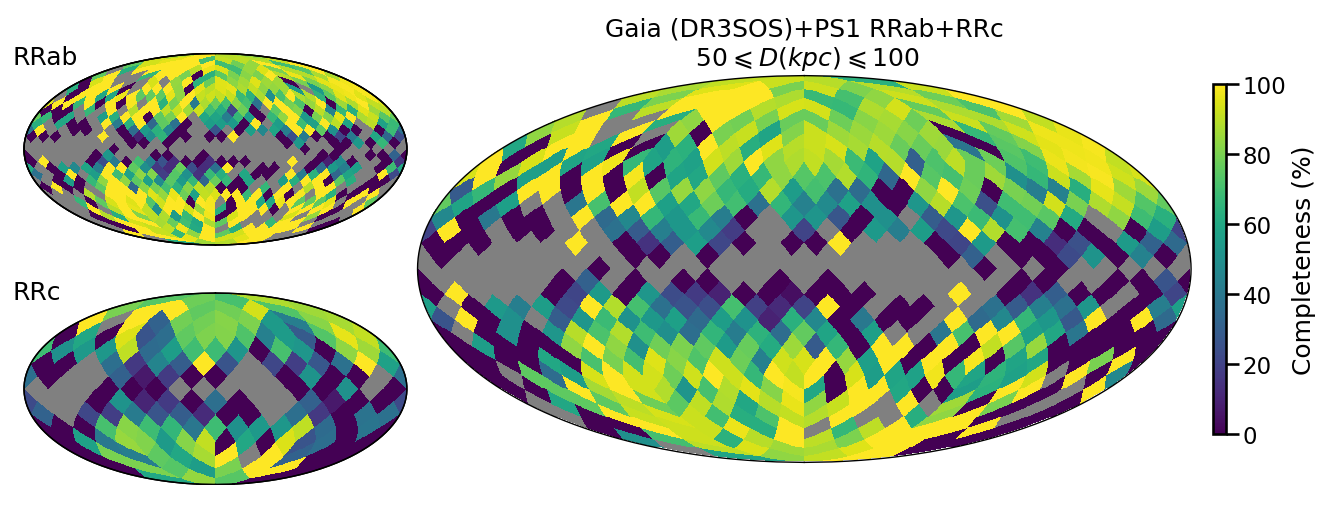

In [98]:
cmap = "viridis"
ccmap=plt.get_cmap(cmap,10)
ccmap.set_bad('gray')
ccmap.set_under('w')

fig=plt.figure(1,figsize=(13,5))
fig.subplots_adjust(wspace=0.02,hspace=0.02,left=0.01,right=0.91,bottom=0.01,top=0.95)
gs=gridspec.GridSpec(nrows=2,ncols=3,hspace=0.04,wspace=0.02)

gth_o=[50.,1.,2.]
gth_f=[100.,2.,2.]
glabel=[f"${gth_o[0]} \leqslant D\leqslant {gth_f[0]}$","x","x"]
rrtypes=["RRab","RRc"]
    
for ii in  range(2):
       
    if ii==0: nside=2**3 
    else: nside=2**2 
        
    jj=0
    rrt = rrtypes[ii]    

    pmasks = (sc_asasps1.distance.kpc > gth_o[jj]) & (sc_asasps1.distance.kpc <= gth_f[jj])
    gmasks = (sc_gaia.distance.kpc > gth_o[jj]) & (sc_gaia.distance.kpc <= gth_f[jj])

    print('Gaia N',rrt,((sc_gaia.RRType==rrt) & gmasks).sum()) 
    
    cat1_coo = sc_asasps1[(sc_asasps1.RRType==rrt) & pmasks] #Cat1 is the reference catalogue
    cat2_coo = sc_gaia[(sc_gaia.RRType==rrt) & gmasks] #Cat2 is the problem catalogue

    #Compute Gaia's completeness maps (valid within each survey's magnitude range) 
    Cap, CG = completeness_utils.compute_completeness_map(cat1_coo, cat2_coo, nside=nside, 
                                                         tol=3.*u.arcsec, verbose=False)

    Cboth = 100*(CG/100 + Cap/100 - (CG/100)*(Cap/100))
    C = Cboth
    C_filled = completeness_utils.fill_with_ecliptic_opposite(np.array(C))
     
    axt=plt.subplot(gs[ii,jj])

    #Gaia Completeness: CG = NGP/P
    if ii==1: title=glabel[jj] #'%.1f<G<%.1f' % (gth_o[jj],gth_f[jj])
    else: title=""  
    hp.mollview(C_filled, cbar=False, title='', 
                unit = 'Completeness ',min=0, max=100., hold=True, cmap=cmap);
    hp.graticule(color='w',alpha=0.,verbose=False,dmer=90.); 

fig = plt.gcf()
axt = plt.gca()
#axt = plt.subplot(gs[0,0])
image = axt.get_images()[0]
#cbax=plt.axes((0.96,0.15,0.015,0.4))

cbax=plt.axes((0.925,0.15,0.01,0.7))
cbar = fig.colorbar(image,cax=cbax,orientation="vertical")#,vmin=0,vmax=100.)
cbar.set_label("Completeness (%)")
# cbar.set_ticks(plt.MultipleLocator(10))
# cbax.tick_params(pad=0.13)    

tax=plt.axes((0.,0.,0.1,1.),frameon=False,)
tax.text(0.02,0.89,"RRab",transform=tax.transAxes,fontweight='normal')
tax.text(0.02,0.42,"RRc",transform=tax.transAxes,fontweight='normal')
tax.axis('off')

#====================================================
#RRab+RRc map
nside =2**3

cat1_coo = sc_asasps1[pmasks] #Cat1 is the reference catalogue
cat2_coo = sc_gaia[gmasks] #Cat2 is the problem catalogue

#Compute Gaia's completeness maps (valid within each survey's magnitude range) 
Cap, CG = completeness_utils.compute_completeness_map(cat1_coo, cat2_coo, nside=nside, 
                                                     tol=3.*u.arcsec, verbose=False)
Cboth = 100*(CG/100 + Cap/100 - (CG/100)*(Cap/100))
C = Cboth
C_filled = completeness_utils.fill_with_ecliptic_opposite(np.array(C))

axt=plt.subplot(gs[0:,1:])

title=glabel[jj] #'%.1f<G<%.1f' % (gth_o[jj],gth_f[jj])
hp.mollview(C_filled, cbar=False, title="Gaia (DR3SOS)+PS1 RRab+RRc\n $50\leqslant D(kpc) \leqslant 100$", 
            unit = 'Completeness ',min=0, max=100., hold=True, cmap=cmap),;
hp.graticule(color='w',alpha=0.,verbose=False,dmer=90.); 


In [150]:
#--------------Gaia's 3D selection function (from x-match against ASAS+PS1)-------------------
nside=2**2
npix = hp.nside2npix(nside)
hpi = np.arange(npix,dtype=int) #healpix indices for current map 
nest=False
los, bos = hp.pix2ang(nside, hpi, lonlat=True, nest=nest)

m_full = (sc_gaia.G<24) 
m_ruwe = sc_gaia.ruwe<1.4
m_bep = sc_gaia.bep<3

m_all = [m_full, m_ruwe, m_bep, m_ruwe & m_bep]
m_lab = ["all","ruwe_lt_1.4", "BEP_lt3", "ruwe_lt_1.4_BEP_lt_3"]

#All surveys
rrt = 'RRab'
#rrt = 'RRc'
for ii in range(len(m_all))[0:1]:

    print(f"--- Computing maps with {m_lab[ii]} mask ----")
    mm = m_all[ii]
    
    cat1_coo = sc_asasps1[sc_asasps1.RRType==rrt] #Cat1 is the reference catalogue
    cat2_coo = sc_gaia[(sc_gaia.RRType==rrt) & mm] #Cat2 is the problem catalogue
    outlabel = dict(gaia = "gaiadr3.sos", ps1="ps1_wgdr3ref", asas="asas_wgdr3ref")
    skytols  = dict(gaia = 3.*u.arcsec, ps1=3.*u.arcsec, asas=5.*u.arcsec)
    fill     = dict(gaia=True, ps1=False, asas=False)
        
    survey = 'gaia'
    
    print(f"Computing completeness for {rrt} in {survey} ...")  

    hpis, ls, bs, ris, rfs = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
    Cs, eCs = np.array([]), np.array([])
    j=0

    for lo, bo in zip(los,bos) :

        #Completeness vs r for lo,bo
        if j % 20 == 0 :   print(f" Computing C(r) for lo={lo:6.2f}, bo={bo:+5.2f} ({j}/{los.size})")      
        los_coo = ac.SkyCoord(lo*u.deg, bo*u.deg, frame='galactic')
        ro, C2, eC2, Ntot1_r, Ncommon_r, Cmean = completeness_utils.completeness_los(los_coo, cat1_coo, cat2_coo, fill_with_ecliptic_opposite=fill[survey],
                                                           los_size=(8.2*2)*u.deg, sky_tol=skytols[survey],
                                                           Nmin=50, verbose=False)
        ro1, C1, eC1, Ntot1_r, Ncommon_r, Cmean = completeness_utils.completeness_los(los_coo, cat2_coo, cat1_coo, fill_with_ecliptic_opposite=fill[survey],
                                                           los_size=(8.2*2)*u.deg, sky_tol=skytols[survey],
                                                           r_bin_edges = ro*u.kpc,                          
                                                           Nmin=50, verbose=False)
        #Combined completeness
        C = C1 + C2 - (C1*C2) #this is back in %
        eC = np.sqrt( eC1**2 + eC2**2 + (C1)*(eC1**2) + (C2)*(eC2**2) )
        
        hpis= np.append(hpis, hpi[j]*np.ones_like(C))
        ls = np.append(ls, lo*np.ones_like(C))
        bs = np.append(bs, bo*np.ones_like(C))
        ris= np.append(ris, ro[:-1])
        rfs= np.append(rfs, ro[1:])
        Cs = np.append(Cs, C)
        eCs= np.append(eCs, eC)
        j+=1
    
    
        #Store in DataFrame     
        printout = pd.DataFrame(data=dict(hpix=hpis,l=ls,b=bs,D_o=ris,D_f=rfs,C=Cs,eC=eCs))
        #Print tex table for paper
        outname=f"gdr3_ps1_asas_combined.filt_{m_lab[ii]}.{rrt.lower()}"
    #     astropy.io.ascii.write(astropy.table.Table.from_pandas(printout), 
    #                             output=f"maps/completeness3d.{outname}.tex", overwrite=True,
    #                             Writer=astropy.io.ascii.Latex,
    #                             formats={'hpix':'%4d','l':'%6.2f','b':'%+5.2f',"D_o":"%5.1f","D_f":"%5.1f","C":"%4.2f","eC":"%4.2f"})
    
        # printout_t = astropy.table.Table.from_pandas(printout)
        # astropy.io.ascii.write(printout_t,output=f"RRL_SF_data/completeness3d.{outname}.dat", 
        #                  overwrite=True,format='fixed_width', delimiter=' ',
        #                  formats={'hpix':'%4d','l':'%6.2f','b':'%+5.2f',"D_o":"%5.1f","D_f":"%5.1f","C":"%4.2f","eC":"%4.2f"})

    #Print csv table for convenience
    printout.to_csv(f"../maps/completeness3d.{outname}.csv",index=False,)

print("Done")

--- Computing maps with all mask ----
Computing completeness for RRab in gaia ...
 Computing C(r) for lo= 45.00, bo=+78.28 (0/192)
 Computing C(r) for lo=255.00, bo=+54.34 (20/192)
 Computing C(r) for lo=  0.00, bo=+30.00 (40/192)
 Computing C(r) for lo=101.25, bo=+19.47 (60/192)
 Computing C(r) for lo=180.00, bo=+9.59 (80/192)
 Computing C(r) for lo=281.25, bo=+0.00 (100/192)
 Computing C(r) for lo= 11.25, bo=-19.47 (120/192)
 Computing C(r) for lo= 90.00, bo=-30.00 (140/192)
 Computing C(r) for lo=191.25, bo=-41.81 (160/192)
 Computing C(r) for lo= 22.50, bo=-66.44 (180/192)
Done


Combined SOS+PS1+ASAS vs line of sight
----------

In [11]:
gaia3Dab = pd.read_csv("../maps/completeness3d.gdr3_ps1_asas_combined.filt_ruwe_lt_1.4.rrab.csv",dtype=dict(hpix=int))
gaia3Dc  = pd.read_csv("../maps/completeness3d.gdr3_ps1_asas_combined.filt_ruwe_lt_1.4.rrc.csv",dtype=dict(hpix=int))

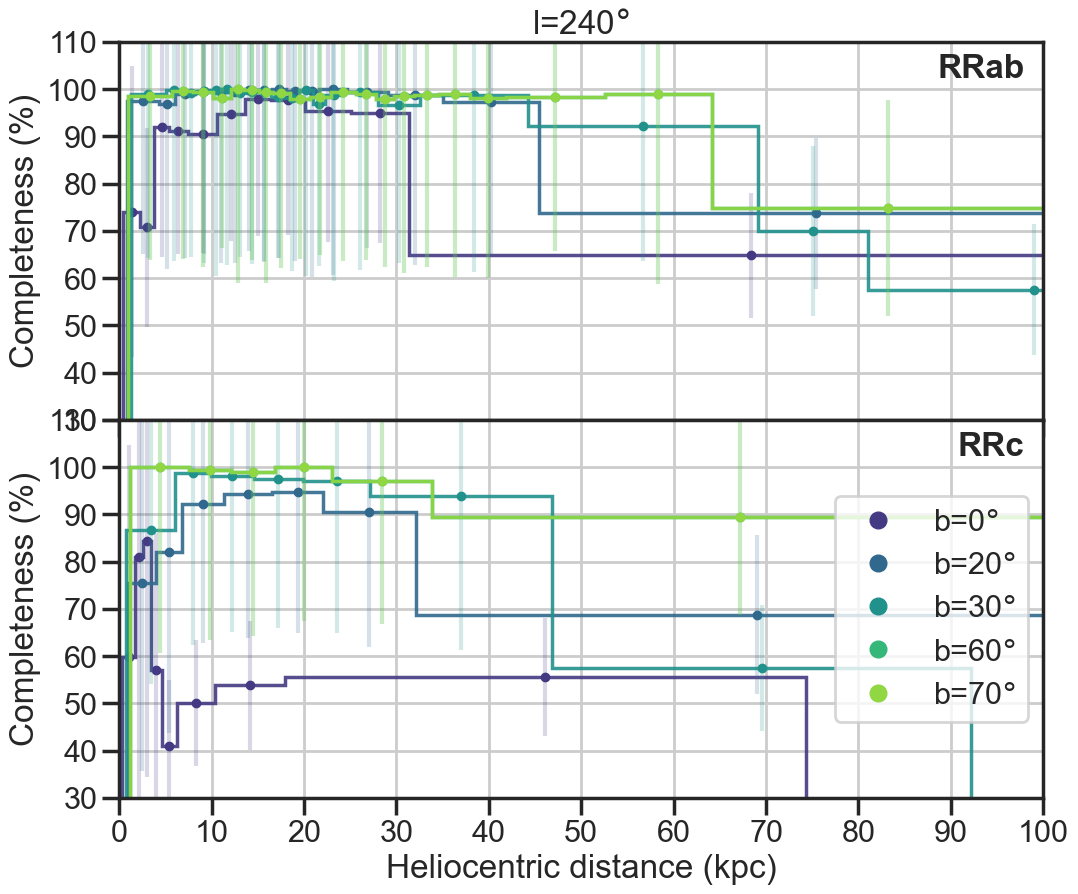

In [34]:
sns.set_style('ticks')
sns.set_context('poster')


fig=plt.figure(1,figsize=(11,9), )
fig.subplots_adjust(left=0.12,right=0.96,top=0.98,bottom=0.14,hspace=0.)
ax=fig.add_subplot(211,)   
ax1=fig.add_subplot(212)   

ls=[5,45,90,145,180]
bs=[0,20,30,60,70]
cols=sns.color_palette("viridis", len(ls))

completeness_map = gaia3Dab

for jj in range(len(ls)) : #np.arange(0,360.,90.):
 
 bo=5.
 lo=ls[jj]
 label = f"l={lo}$\degree$" 
    
 lo=240.
 bo=bs[jj]
 label=f"b={bo}$\degree$"   

 #RRAB    
 coo = ac.SkyCoord(l = lo*u.deg, b = bo*u.deg, frame = 'galactic')
 losC = completeness_utils.query_3d_map(gaia3Dab ,coo)   
    
 rmid = (losC.D_f+losC.D_o)/2.
 rs = np.append(np.min(losC["D_o"]),losC["D_f"])

 ax.plot(rmid,losC.C*100,'.',color=cols[jj])
 #The histogram plot gives a better representation of the data. Completeness was estimated in (non-uniform) distance bins to ensure a given Poisson noise.
 ax.hist(rmid,weights=losC.C*100,bins=rs,histtype='step',lw=2.5,color=cols[jj],alpha=0.9)
 ax.errorbar(rmid,losC.C*100,yerr=losC.eC*100,marker=None,alpha=0.2,color=cols[jj],ls='none')
 
 #RRC   
 losC = completeness_utils.query_3d_map(gaia3Dc ,coo)   
    
 rmid = (losC.D_f+losC.D_o)/2.
 rs = np.append(np.min(losC["D_o"]),losC["D_f"])

 ax1.plot(rmid,losC.C*100,'.',color=cols[jj],label=label)
 #The histogram plot gives a better representation of the data. Completeness was estimated in (non-uniform) distance bins to ensure a given Poisson noise.
 ax1.hist(rmid,weights=losC.C*100,bins=rs,histtype='step',lw=2.5,color=cols[jj],alpha=0.9)
 ax1.errorbar(rmid,losC.C*100,yerr=losC.eC*100,marker=None,alpha=0.2,color=cols[jj],ls='none')

ax.set_title(f'l={lo:.0f}$\degree$')
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax1.xaxis.set_major_locator(plt.MultipleLocator(10))

ax.yaxis.set_major_locator(plt.MultipleLocator(10))
ax1.yaxis.set_major_locator(plt.MultipleLocator(10))

ax.grid(which='major')
ax1.grid(which='major')

#ax.legend(markerscale=2, ncol=2, loc='lower left')

ax.set_xlim(0,100)
ax1.set_xlim(0,100)
ax.xaxis.set_ticklabels([])
ax1.set_xlabel('Heliocentric distance (kpc)')

ax.set_ylabel('Completeness (%)')
ax1.set_ylabel('Completeness (%)')

ax.text(0.98,0.97,'RRab',fontweight='bold',ha='right',va='top', transform=ax.transAxes)
ax1.text(0.98,0.97,'RRc',fontweight='bold',ha='right',va='top', transform=ax1.transAxes)


ax.set_ylim(30,110)
ax1.set_ylim(30,110)

#ax1.legend()
ax1.legend(markerscale=2, loc='center right')#, loc='lower left')

Comparison of GaiaSOSDR3 and G+PS1
-------------

96.15384615384616 64.1025641025641 59.81093712215971
81.25 91.2133891213389 84.72759689221623
15 18 filling
40.68287037037037 78.94736842105263 73.38508138187781
18 21 filling


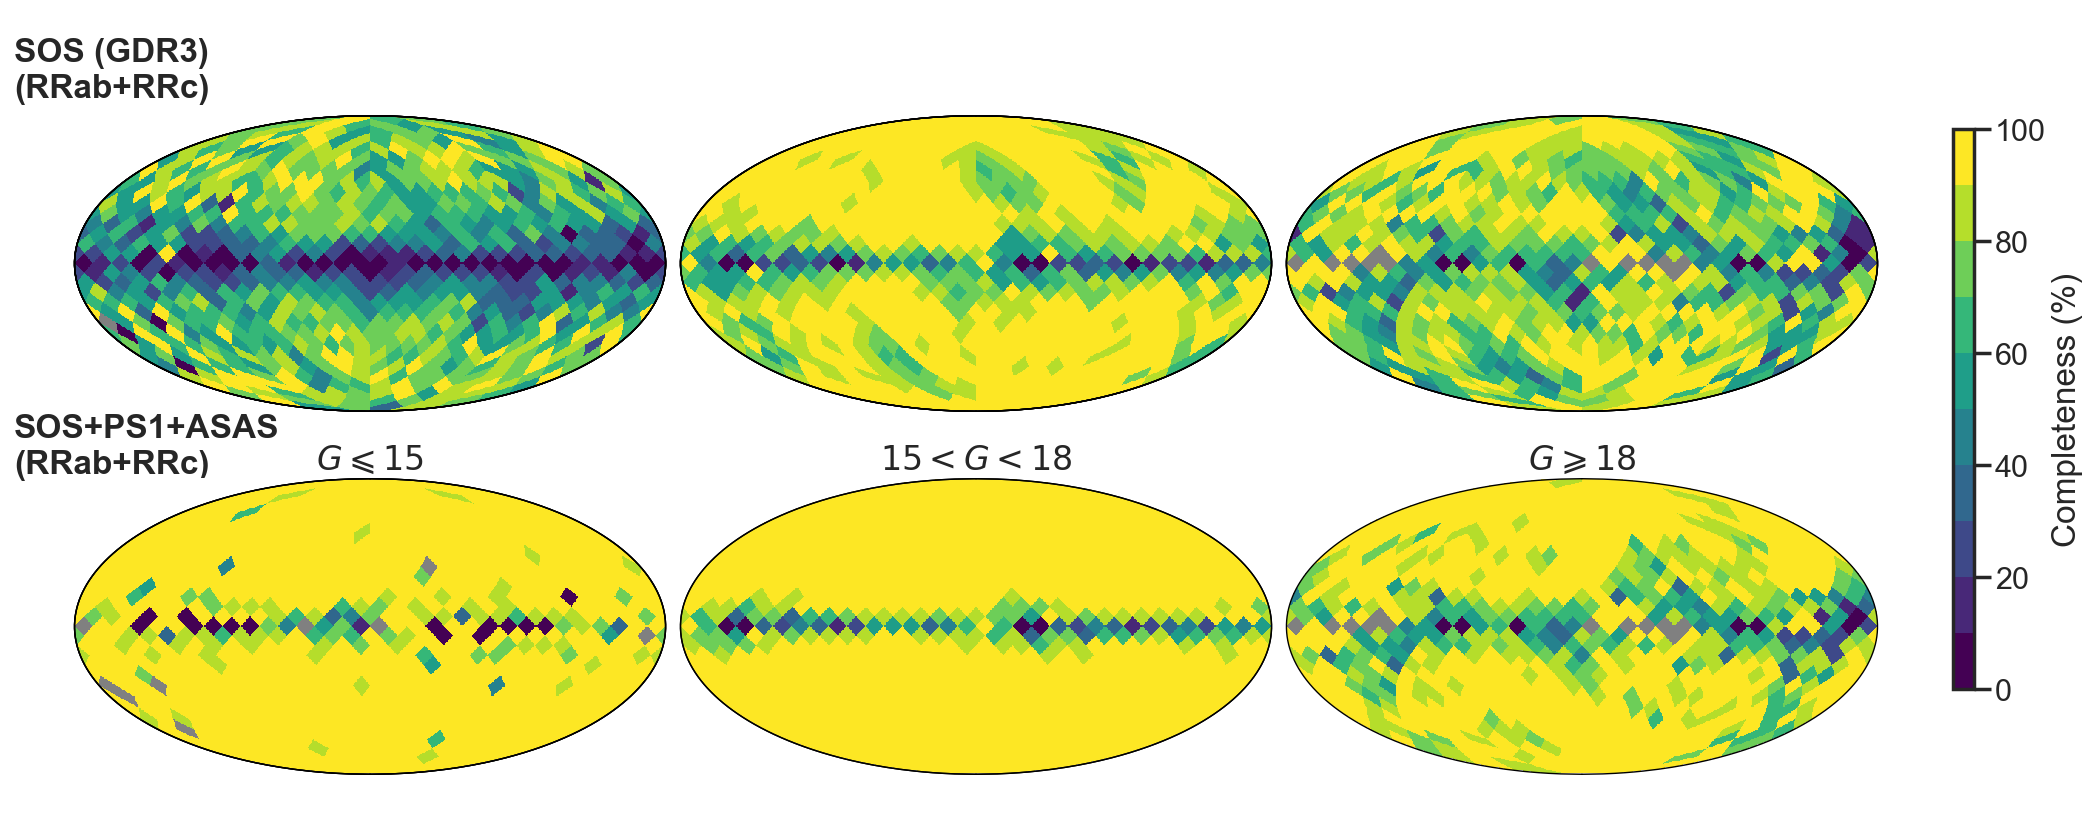

In [184]:
ccmap=plt.get_cmap("viridis",10)
ccmap.set_bad('gray')
ccmap.set_under('w')

rrtypes=["RRab","RRc"]


fig=plt.figure(1,figsize=(21,8))
fig.subplots_adjust(wspace=0.03,hspace=0.02,left=0.03,right=0.89,bottom=0.01,top=0.9)
gs=gridspec.GridSpec(nrows=2,ncols=3,hspace=0.04,wspace=0.02)

gth_o=[10.,15,18]
gth_f=[15,18,21]
#glabel=["$13\leqslant G\leqslant 15$","$15<G<18$","$G\geqslant 18$"]
glabel=[f"$G \leqslant {gth_f[0]}$",
        f"${gth_o[1]}<G<{gth_f[1]}$",
        f"$G\geqslant {gth_o[2]}$"]

for jj in range(3):
    
    ii=0   
    nside=2**3 

    #Gaia DR3--------
    pmasks = (sc_asasps1.G > gth_o[jj]) & (sc_asasps1.G <= gth_f[jj])
    gmasks = (sc_gaia.G > gth_o[jj]) & (sc_gaia.G <= gth_f[jj]) & (sc_gaia.ruwe<1.4)
     
    cat1_coo = sc_asasps1[pmasks] #Cat1 is the reference catalogue
    cat2_coo = sc_gaia[gmasks] #Cat2 is the problem catalogue

    #Compute Gaia's completeness maps (valid within each survey's magnitude range) 
    Cap, CG = completeness_utils.compute_completeness_map(cat1_coo, cat2_coo, nside=nside, 
                                                         tol=3.*u.arcsec, verbose=False)
    print(np.nanmedian(Cap),np.nanmedian(CG),np.nanmean(CG),)

    if gth_f[jj]<17: CG_filled = CG.copy()
    else:    
        print(gth_o[jj],gth_f[jj],'filling')
        CG_filled = completeness_utils.fill_with_ecliptic_opposite(np.array(CG))
     
    axt=plt.subplot(gs[ii,jj])

    #Gaia Completeness: CG = NGP/P
    if ii==1: title=glabel[jj] #'%.1f<G<%.1f' % (gth_o[jj],gth_f[jj])
    else: title=""  
    hp.mollview(CG_filled, cbar=False, title=title, 
                unit = 'Completeness ',min=0, max=100., hold=True, cmap=ccmap);
    hp.graticule(color='w',alpha=0.,verbose=False,dmer=90.); 

fig = plt.gcf()
axt = plt.gca()
#axt = plt.subplot(gs[0,0])
image = axt.get_images()[0]
#cbax=plt.axes((0.96,0.15,0.015,0.4))

cbax=plt.axes((0.925,0.15,0.01,0.7))
cbar = fig.colorbar(image,cax=cbax,orientation="vertical")#,vmin=0,vmax=100.)
cbar.set_label("Completeness (%)")
# cbar.set_ticks(plt.MultipleLocator(10))
# cbax.tick_params(pad=0.13)    

tax=plt.axes((0.,0.,0.1,1.),frameon=False,)
tax.text(0.02,0.89,"SOS (GDR3)\n(RRab+RRc)",transform=tax.transAxes,fontweight='bold')
tax.text(0.02,0.42,"SOS+PS1+ASAS\n(RRab+RRc)",transform=tax.transAxes,fontweight='bold')
tax.axis('off')

#Combined----------    
ii=1
for jj in range(3):
    
       
    nside=2**3 

    pmasks = (sc_asasps1.G > gth_o[jj]) & (sc_asasps1.G <= gth_f[jj])
    gmasks = (sc_gaia.G > gth_o[jj]) & (sc_gaia.G <= gth_f[jj]) & (sc_gaia.ruwe<1.4)
        
    cat1_coo = sc_asasps1[pmasks] #Cat1 is the reference catalogue
    cat2_coo = sc_gaia[gmasks] #Cat2 is the problem catalogue
    
    #Compute Gaia's completeness maps (valid within each survey's magnitude range) 
    Cap, CG = completeness_utils.compute_completeness_map(cat1_coo, cat2_coo, nside=nside, 
                                                         tol=3.*u.arcsec, verbose=False)
    
    Cboth = 100*(CG/100 + Cap/100 - (CG/100)*(Cap/100))
    C = Cboth
    C_both_filled = completeness_utils.fill_with_ecliptic_opposite(np.array(C))
    
    axt=plt.subplot(gs[ii,jj])

    #Gaia Completeness: CG = NGP/P
    if ii==1: title=glabel[jj] #'%.1f<G<%.1f' % (gth_o[jj],gth_f[jj])
    else: title=""  
    hp.mollview(C_both_filled, cbar=False, title=title, 
                unit = 'Completeness ',min=0, max=100., hold=True, cmap=ccmap);
    hp.graticule(color='w',alpha=0.,verbose=False,dmer=90.); 

    
#plt.savefig("VCSOS_PS1_RRL_completeness_G_maps.png")
plt.savefig("/Users/cmateu/trabajo/research/rrl_distances/extendedGDR2_RRL/paper_rnaas_dr3_completeness/fig_dr3_maps.png")